In [ ]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)
terminal = sys.stdout

Mounted at /content/drive


In [ ]:
import h5py

file = "/content/drive/My Drive/Colab Notebooks/dataset_comp_image_spectra.h5"
# file = "/content/drive/Shared with me/Colab Notebooks/dataset_comp_image_spectra.h5"
hf = h5py.File(file, 'r')

def h5_items(file):
    for key in file:
        if isinstance(file[key],h5py.Dataset):
                print('' + key + ':' + str(file[key].shape))
        else:
            print('' + key)
            h5_items(file[key])
subsetSize=20000
splicingVal = 11
numOutputs = int(220/splicingVal)
sample = hf["sample_id"][0:subsetSize]
imgs = hf['images'][0:subsetSize]
spectra = hf['spectra'][0:subsetSize]
spectra = np.array([x[::splicingVal] for x in spectra])
x_train, x_test, y_train, y_test = train_test_split(imgs, spectra, test_size = 0.2, random_state = None)

In [ ]:
def custom_loss(y_true, y_pred):
  #shape of y_true/y_pred = (batchSize, numOutputs)
  #distance metric
  lossDistance = tf.square(y_pred - y_true)
  return lossDistance
  #smoothness metric
  Deriv2 = 0
  for batch in range(batchSize):
    for i in range(numOutputs):
      if i == numOutputs - 3:
        break
      Deriv2 += 1

def SMU(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU_mu', shape=(),
                       initializer=tf.constant_initializer(1000000),
                       dtype=tf.float32)
    return ((1+alpha)*x + (1-alpha)*x*tf.math.erf(mu*(1-alpha)*x))/2

def SMU1(x,alpha=0.25):
    mu = tf.compat.v1.get_variable('SMU1_mu', shape=(),
                       initializer=tf.constant_initializer(4.352665993287951e-9),
                       dtype=tf.float32)
    return ((1+alpha)*x+tf.math.sqrt(tf.math.square(x-alpha*x)+tf.math.square(mu)))/2

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

#get_custom_objects().update({'SMU': Activation(SMU)}) 
#get_custom_objects().update({'SMU1': Activation(SMU1)}) 

In [ ]:
from keras.backend import softsign

# Best Model
def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation= softsign)])
    #tf.keras.layers.Dropout(rate = .6 , noise_shape=None, seed=None)
    model.summary()
    model.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam', metrics = ['accuracy'])
    return model

In [ ]:
from keras.backend import softsign

# Testing Model
def get_conv_model_normal():

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=numOutputs, activation= softsign)])
    #tf.keras.layers.Dropout(rate = .6 , noise_shape=None, seed=None)
    model.summary()
    model.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam', metrics = ['accuracy'])
    return model

In [ ]:
import sys
sys.stdout = open('EpochOutput.txt', 'w') 
numNetworks = 5
modelList = []
historyList= []
epochs = 50
batch_size = 32
#trainSub = int(len(x_train)/numNetworks)
#testSub =  int(len(x_test)/numNetworks)
for i in range(numNetworks):
  normal_model = get_conv_model_normal()
  normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, validation_data = (x_test, y_test), verbose = 1)
  modelList.append(normal_model)
  historyList.append(normal_history)
sys.stdout = terminal

In [ ]:
def makePredictionsList(modelList, data):
  return [model.predict(data) for model in modelList]
  
def ensemblePredictArithAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 0
  for predict in predictList:
    prediction += predict[ele]
  return prediction/numNetworks

def ensemblePredictGeoAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 1
  for predict in predictList:
    prediction *= np.abs(predict[ele])
  return prediction**(1/numNetworks)

def ensemblePredictHarmAverage(predictList, ele):
  numNetworks = len(predictList)
  prediction = 0
  for predict in predictList:
    prediction += 1/(predict[ele])
  return numNetworks/prediction

    

In [ ]:
# neural network from ensemble
# fix data input tho
# x_train, x_test, y_train, y_test = train_test_split(imgs, spectra, test_size = 0.2, random_state = None)
def get_model_from_ensemble():
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (numNetworks, numOutputs)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(units=20, activation='softsign')
    ])
    model.summary()
    model.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(), optimizer = 'adam', metrics = [metrics.mean_squared_logarithmic_error, metrics.mean_absolute_percentage_error]))
    return model

In [ ]:
#fix input shape
modelInput = makePredictionsList(modelList, imgs)
modelInput = np.transpose(modelInput, (1, 0, 2))

sys.stdout = open('EpochOutput2.txt', 'w') 
epochs = 50
batch_size = 32
x_train2, x_test2, y_train2, y_test2 = train_test_split(modelInput, spectra, test_size = 0.2, random_state = None)
final_model = get_model_from_ensemble()
final_history = final_model.fit(x_train2, y_train2, batch_size = batch_size,
              epochs = epochs, validation_data = (x_test2, y_test2), verbose = 1)
sys.stdout = terminal

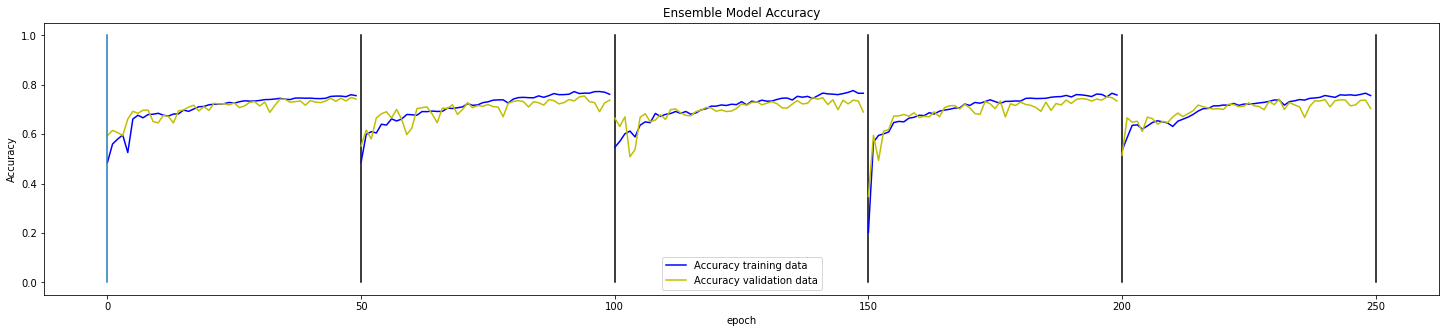

In [ ]:
fig = plt.figure(figsize=(25, 5))

for i, normal_history in enumerate(historyList):
  x = np.array([x for x in range(50)])
  plt.plot(x + 50*i, normal_history.history['accuracy'], color = 'b')
  plt.plot(x + 50*i, normal_history.history['val_accuracy'], color = 'y')
  plt.plot([50*(i+1),50*(i+1)],[0,1], color='black')
  plt.title('Ensemble Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.savefig('ModelAccuracyEnsemble.jpg') 
  plt.legend(['Accuracy training data', 'Accuracy validation data'])
plt.plot([0,0],[0,1])
plt.show()

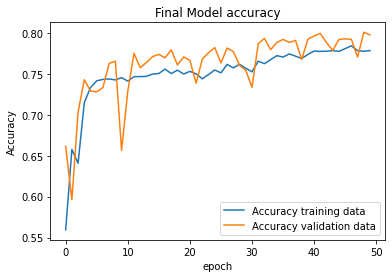

In [ ]:
plt.plot(final_history.history['accuracy'], label='Accuracy training data')
plt.plot(final_history.history['val_accuracy'], label='Accuracy validation data')
plt.legend()
plt.title('Final Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.savefig('ModelAccuracyFinal.jpg')
plt.show()

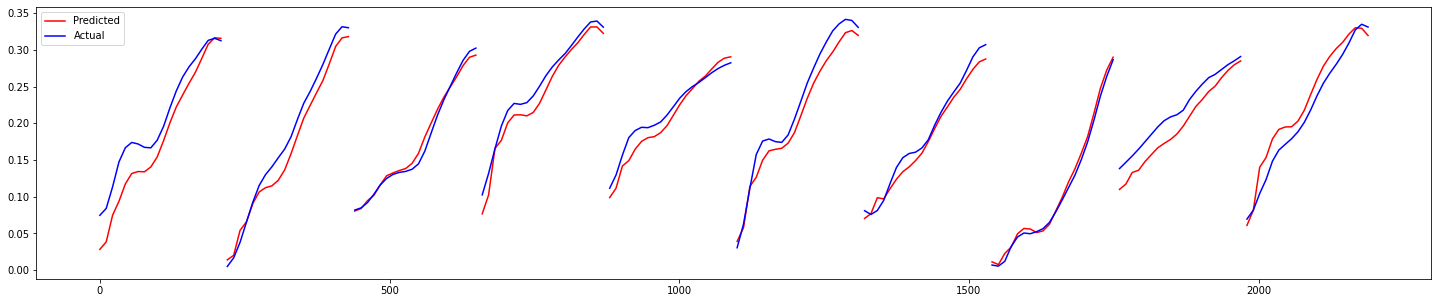

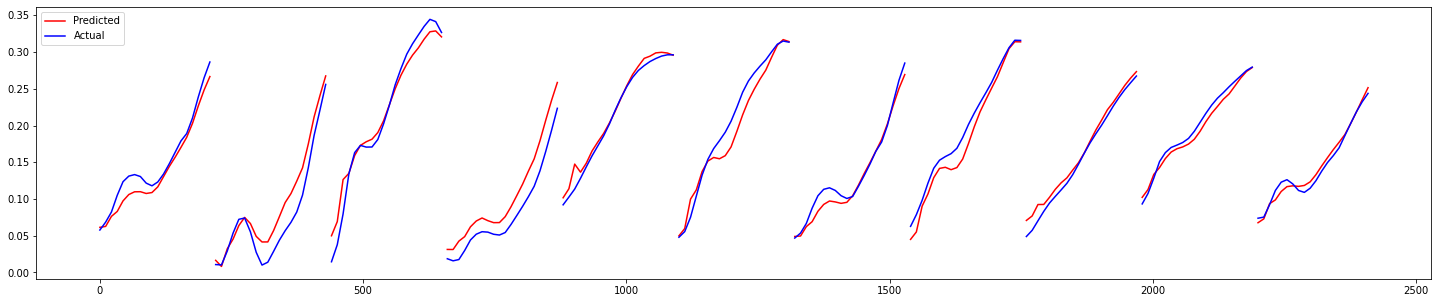

In [ ]:
import random
#Make First 10 images on 1 graph
x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
#y_Arith = [ensemblePredictArithAverage(predictList, ele) for ele in range(len(x_train))]
y_Geo = [ensemblePredictGeoAverage(predictList, ele) for ele in range(len(x_train))]
#y_Harm = [ensemblePredictHarmAverage(predictList, ele) for ele in range(len(x_train))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  #plt.plot(x + 220*i, y_Arith[i] , color = 'y')
  plt.plot(x + 220*i, y_Geo[i] , color = 'r')
  #plt.plot(x + 220*i, y_Harm[i] , color = 'g')
  plt.plot(x + 220*i, y_train[i], color = 'b')
  plt.legend(['Predicted', 'Actual'], loc='upper left')
  #plt.legend(['Arithmetic', 'Geometric', 'Harmonic', 'Actual'], loc='upper left')
plt.savefig('First10Avg.jpg')
plt.show()

#Make Random 10 images on 1 graph
rando = [x for x in range(10, len(y_Geo))]
random.shuffle(rando)
i = 0
fig = plt.figure(figsize=(25, 5))
for rand in rando:
  if i > 10:
    break
  #plt.plot(x + 220*i, y_Arith[rand], color = 'y')
  plt.plot(x + 220*i, y_Geo[rand] , color = 'r')
  #plt.plot(x + 220*i, y_Harm[rand] , color = 'g')
  plt.plot(x + 220*i, y_train[rand], color = 'b')
  #plt.legend(['Arithmetic', 'Geometric','Harmonic', 'Actual'], loc='upper left')
  plt.legend(['Predicted', 'Actual'], loc='upper left')
  i+=1
plt.savefig('Random10Avg.jpg')
plt.show()

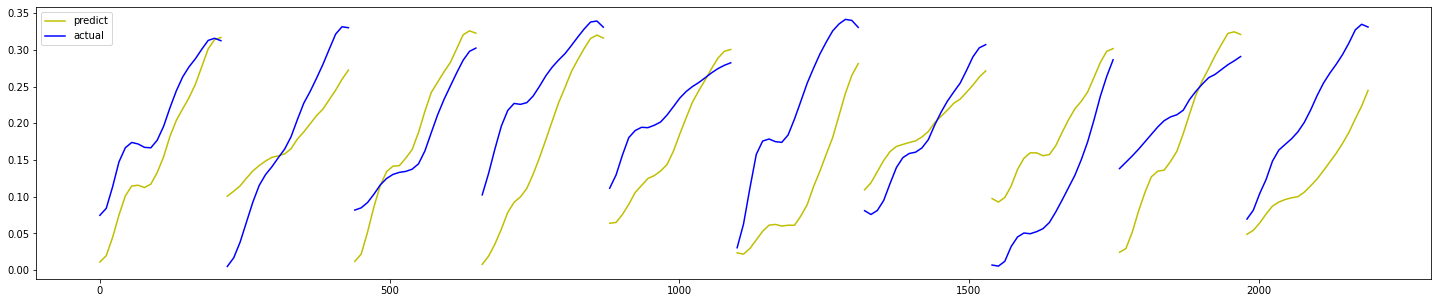

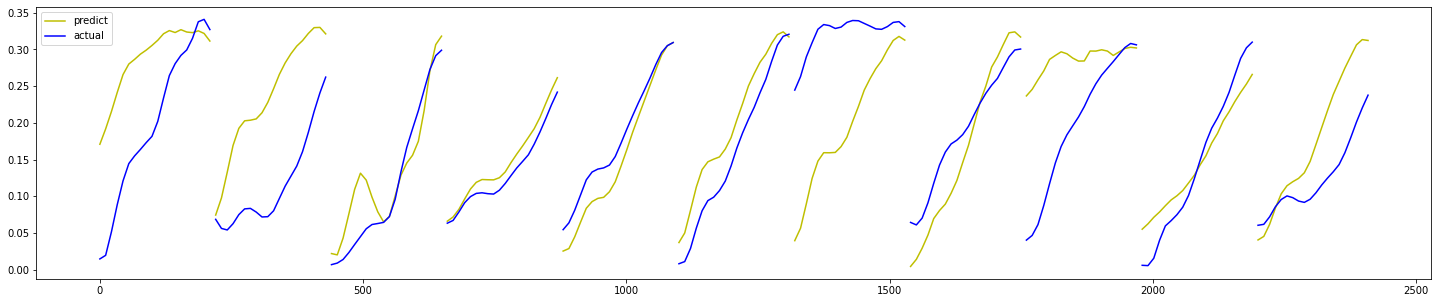

In [ ]:
import random
#Make First 10 images on 1 graph
x = np.array([x for x in range(0,220,11)])
y = final_model.predict(x_train2)
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x + 220*i, y[i] , color = 'y')
  plt.plot(x + 220*i, y_train[i], color = 'b')
  plt.legend(['predict', 'actual'], loc='upper left')
plt.savefig('First10NN.jpg')
plt.show()

#Make Random 10 images on 1 graph
rando = [x for x in range(10, len(y))]
random.shuffle(rando)
i = 0
fig = plt.figure(figsize=(25, 5))
for rand in rando:
  if i > 10:
    break
  plt.plot(x + 220*i, y[rand], color = 'y')
  plt.plot(x + 220*i, y_train[rand], color = 'b')
  plt.legend(['predict', 'actual'], loc='upper left')
  i+=1
plt.savefig('Random10NN.jpg')
plt.show()

In [ ]:
# Use this if we want to load an already built model
normal_model = load_model('Model.h5')

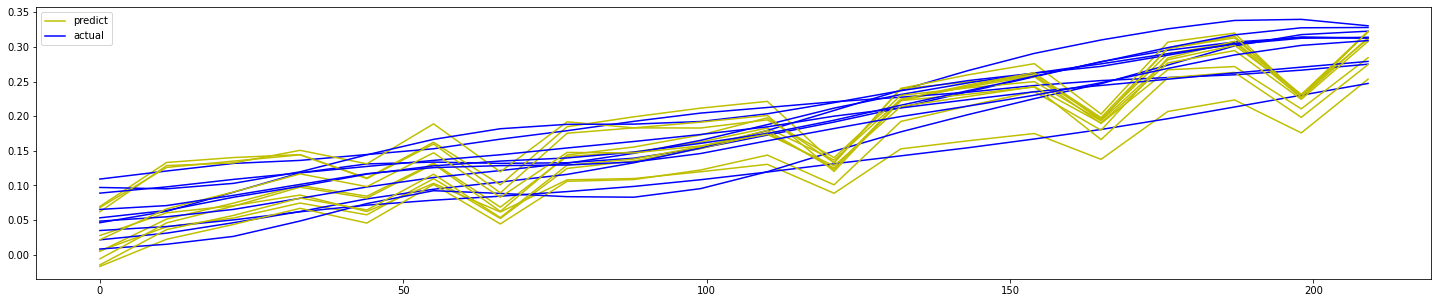

In [ ]:
import random
#Make First 10 predictions all on the same graph
x = np.array([x for x in range(0,220,splicingVal)])
predictList = makePredictionsList(modelList, x_train)
y = [ensemblePredictAverage(predictList, ele) for ele in range(len(x_train))]
fig = plt.figure(figsize=(25, 5))
for i in range(10):
  plt.plot(x, y[i] , color = 'y')
  plt.plot(x, y_train[i], color = 'b')
  plt.legend(['predict', 'actual'], loc='upper left')
plt.savefig('AllPredictions.jpg')
plt.show()

In [ ]:
# this uploads the colab_link to your google drive and the files will be in models

import shutil
names = ['EpochOutput.txt', 'EpochOutput2.txt', 'First10Avg.jpg', 'First10NN.jpg', 'Random10Avg.jpg', 'Random10NN.jpg', 'ModelAccuracyEnsemble.jpg', 'ModelAccuracyFinal.jpg']
for name in names:
  colab_link = name
  gdrive_link = "/content/drive/My Drive/Colab Notebooks/Models"
  shutil.copy(colab_link, gdrive_link)